### Introduction

In this notebook we'll take a look at how we can cluster a set of chemical structures using the k-means algorithm.

In [1]:
import rdkit
import pandas as pd
import numpy as np
import seaborn as sns
import mols2grid
import matplotlib.cm as cm
from typing import List, Optional, Callable
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit import Chem
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from rdkit.Chem import rdFingerprintGenerator

In [2]:
sns.set()
sns.set(rc={'figure.figsize': (7, 7)})
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
def mol2morgan_fp(mol, radius: int = 2, fpSize: int = 2048) -> DataStructs.ExplicitBitVect:
    """Convert an RDKit molecule to a Morgan fingerprint

    :param mol: RDKit molecule
    :param radius: fingerprint radius
    :param nBits: number of fingerprint bits
    :return: RDKit Morgan fingerprint
    """

    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    fp = fpgen.GetFingerprint(mol)
    return fp

In [4]:
tqdm.pandas()

Read the input data

In [5]:
smiles_data = "../data/cluster_test.smi"
df = pd.read_csv(smiles_data,sep=" ",names=["SMILES","Name"])

Add molecular fingerprints to the dataframe

In [6]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)
df['fp'] = df.mol.progress_apply(mol2morgan_fp)

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

Convert the fingerprints to an X matrix to make sklearn happy

In [7]:
X = np.stack(df.fp)

Clustering with k-means only requires a few lines of code

In [8]:
num_clusters = 8
km = KMeans(n_clusters=num_clusters,random_state=42,n_init='auto')
km.fit(X)
cluster_list = km.predict(X)

Plot the cluster populations

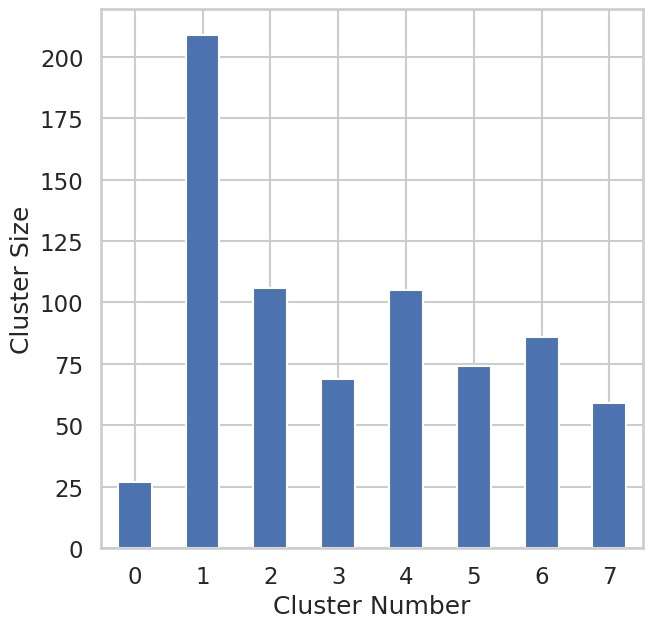

In [9]:
ax = pd.Series(cluster_list).value_counts().sort_index().plot(kind="bar")
ax.set_xlabel("Cluster Number")
ax.set_ylabel("Cluster Size")
ax.tick_params(axis='x', rotation=0)

One potential drawback of k-means clustering is that it requires you to specify the number of clusters.  One means of determining the optimal number of clusters is by maximizing the silhouette score. 

Silhouette Score =  $\frac{(a-b)}{max(a,b)}$ where **a** is the average intracluster distance and **b** is the average intercluster distance.  The Silhouette Score ranges between -1 and 1 with a vaule closer to 1 representing a good match between a point and other members of the same cluster.  

In [10]:
cluster_range = range(5,25)
score_list = []
for k in tqdm(cluster_range):
    km = KMeans(n_clusters=k,random_state=42,n_init='auto')
    cluster_labels = km.fit_predict(X)
    score = silhouette_score(X,cluster_labels)
    score_list.append([k,score])

  0%|          | 0/20 [00:00<?, ?it/s]

Put the silhouette scores into a dataframe

In [11]:
score_df = pd.DataFrame(score_list,columns=["K","Silhouette Score"])
score_df.head()

,K,Silhouette Score
0,5,0.303961
1,6,0.332428
2,7,0.271935
3,8,0.318196
4,9,0.263386


Plot the silhouette scores as a function of the number of clusters

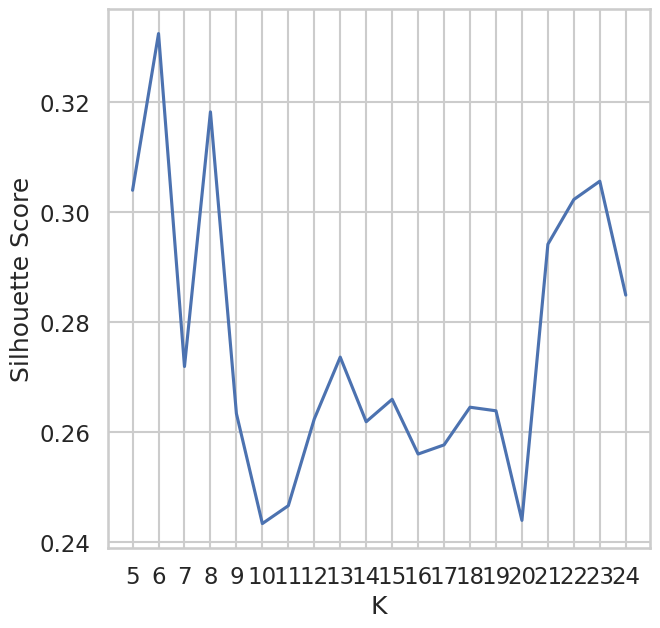

In [12]:
ax = sns.lineplot(x="K",y="Silhouette Score",data=score_df)
ax.set_xticks(cluster_range);

In the figure above the minimum silhouette score is observed with 13 clusters.  Let's run KMeans with num_clusters = 13.

In [13]:
num_clusters = 7
km_opt = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
clusters_opt = km_opt.fit_predict(X)

Routine to plot a silhouette plot

In [14]:
def silhouette_plot(X,cluster_labels):
    """
    Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    """
    sns.set_style('whitegrid')
    sample_df = pd.DataFrame(silhouette_samples(X,cluster_labels),columns=["Silhouette"])
    sample_df['Cluster'] = cluster_labels
    n_clusters = max(cluster_labels+1)
    color_list = [cm.nipy_spectral(float(i) / n_clusters) for i in range(0,n_clusters)]
    ax = sns.scatterplot()
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    y_lower = 10
    unique_cluster_ids = sorted(sample_df.Cluster.unique())
    for i in unique_cluster_ids:
        cluster_df = sample_df.query('Cluster == @i')
        cluster_size = len(cluster_df)
        y_upper = y_lower + cluster_size
        ith_cluster_silhouette_values = cluster_df.sort_values("Silhouette").Silhouette.values
        color = color_list[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i),fontsize="small")
        y_lower = y_upper + 10
    ax.axvline(silhouette_avg,color="red",ls="--")
    ax.set_xlabel("Silhouette Score")
    ax.set_ylabel("Cluster")
    ax.set(yticklabels=[]) 
    ax.yaxis.grid(False) 

Plot a sihouette plot for the clustering above.  When we do this, we're looking for two things. 
1. How uniform are the sizes of the clusters (represeneted by the widths of the bars in the plot below).
2. How consistent are the Silhoutte Scores for the inidividual clusters.  

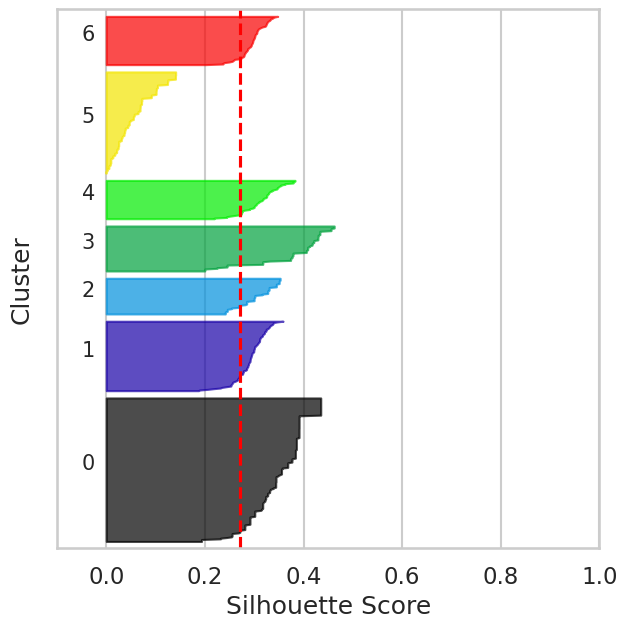

In [15]:
silhouette_plot(X,clusters_opt)

Make a TSNE plot of the clustering

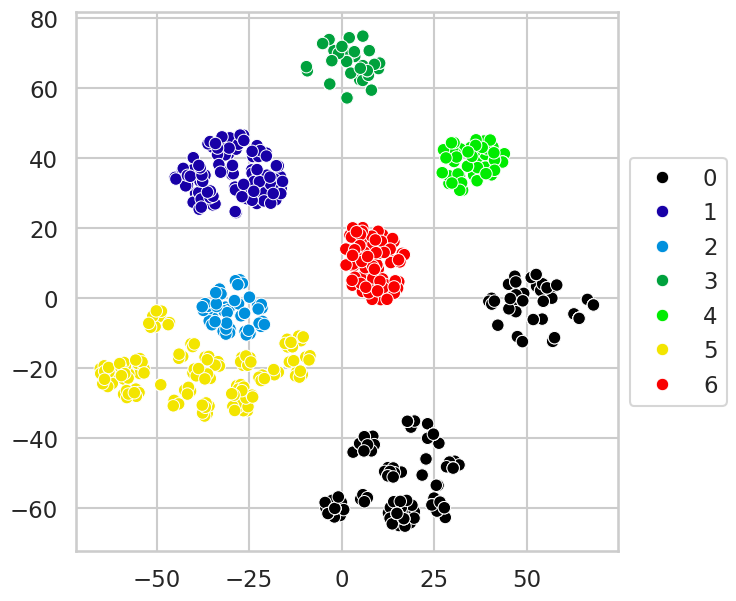

In [16]:
tsne = TSNE(n_components=2, init='pca',learning_rate='auto')
crds = tsne.fit_transform(X,clusters_opt)
color_list = [cm.nipy_spectral(float(i) / num_clusters) for i in range(0,num_clusters)]
ax = sns.scatterplot(x=crds[:,0],y=crds[:,1],hue=clusters_opt,palette=color_list,legend=True)
ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.75), ncol=1);

Add a cluster column to our input dataframe

In [17]:
opt_cluster_df = df.copy()
opt_cluster_df['Cluster'] = clusters_opt

Display structures of the cluster members

In [18]:
cluster_id = 1
cols = ["SMILES","Name","Cluster"]
display_df = opt_cluster_df[cols].query("Cluster == @cluster_id")
mols2grid.display(display_df,subset=["img"],n_cols=3,size=(320,240))

MolGridWidget()

Write the clusters to a csv file

In [19]:
opt_cluster_df[["SMILES","Name","Cluster"]].to_csv("clusters.csv",index=False)